In [1]:
import numpy as np
import treecorr
import des_functions as des
from more_itertools import locate
import time
import astropy.io.fits as fits 
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
data_dir = '/home/b7009348/WGL_project/DES-data/'

In [2]:
# define the parameters to be used in all calculations
sep_bins = 20
npatches = 20
f_bins = 810
theta_min = 2.5
theta_max = 250.0

In [3]:
lens_file = 'DES_Y1A1_Lenses_z=0.3-0.45.fits'
rand_file = 'DES_Y1A1_3x2pt_redMaGiC_RANDOMS.fits'
im3_file = 'y1_im3_shapes_matched.fits'
mcal_file = 'y1_mcal_shapes_matched.fits'
z_file = 'mof_BPZ_(stacking).fits'

### Create functions to calculate tangential shear & boost

In [4]:
def im3_tang_shear(lens_cat, source_cat, sens_cat, rand_cat):
    
    # preallocate output arrays
    gammat = np.zeros([sep_bins])
    theta = np.zeros([sep_bins])
    
    # carry out tangential shear calculation with lenses
    ng = treecorr.NGCorrelation(nbins=sep_bins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    ng.process(lens_cat, source_cat)
    # calculate multiplicative bias correction with lenses
    nk = treecorr.NKCorrelation(nbins=sep_bins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    nk.process(lens_cat, sens_cat)
    
    # carry out tangential shear calculation with randoms
    rg = treecorr.NGCorrelation(nbins=sep_bins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rg.process(rand_cat, source_cat)
    # calculate multiplicative bias correction with randoms
    rk = treecorr.NKCorrelation(nbins=sep_bins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rk.process(rand_cat, sens_cat)
    
    # collect outputs 
    xi_l = ng.xi
    sens_l = nk.xi
    xi_r = rg.xi
    sens_r = rk.xi
    
    # calculate and save tangential shear + theta
    gammat = xi_l/sens_l - xi_r/sens_r
    theta = np.exp(ng.meanlogr)
    
    return gammat, theta

def mcal_tang_shear(lens_cat, source_cat, rand_cat, Rsp):
    
    # preallocate output arrays
    gammat = np.zeros([sep_bins])
    theta = np.zeros([sep_bins])
    
    # calculate tangential shear with lenses
    ng = treecorr.NGCorrelation(nbins=sep_bins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    ng.process(lens_cat, source_cat)
    
    # calculate tangential shear with randoms
    rg = treecorr.NGCorrelation(nbins=sep_bins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rg.process(rand_cat, source_cat)
    
    xi_l = ng.xi
    xi_r = rg.xi
    
    gammat = 1.0/Rsp * (xi_l - xi_r)
    theta = np.exp(ng.meanlogr)
    
    return gammat, theta

def calculate_boost(lens_cat, rand_cat, source_cat):
    
    # preallocate array
    boost = np.zeros(sep_bins)
    
    ls = treecorr.NNCorrelation(nbins=sep_bins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    ls.process(lens_cat, source_cat)
    
    rs = treecorr.NNCorrelation(nbins=sep_bins, min_sep=theta_min, max_sep=theta_max, sep_units='arcmin')
    rs.process(rand_cat, source_cat)
    
    nrand = rand_cat.nobj
    nlens = lens_cat.nobj
    
    boost = nrand/nlens * ls.weight/rs.weight
    
    return boost

### Create catalogues for IA jackknife

In [32]:
start=time.time()

with fits.open(data_dir+lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
del data
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l, npatch=npatches)

del ra_l, dec_l, w_l

with fits.open(data_dir+rand_file) as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45))
    ra_r = data['RA'][indexes]
    dec_r = data['DEC'][indexes]
    rand_z = data['z'][indexes]
del data

cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg', r=rand_z, patch_centers=cat_l.patch_centers)

del indexes, ra_r, dec_r, rand_z

with fits.open(data_dir+mcal_file) as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1']
    e2 = data['e2']
    R11 = data['R11']
del data

cat_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', r=R11, g1=e1, g2=e2, patch_centers=cat_l.patch_centers)

del ra_s, dec_s, e1, e2, R11

with fits.open(data_dir+im3_file) as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1'] - data['c1']
    e2 = data['e2'] - data['c2']
    sens = data['m'] + 1.0
    w = data['weight']
del data

with fits.open(data_dir+z_file) as hdu:
    data = hdu[1].data
    zmc = data['z_mc']
    zmc_ID = data['coadd_objects_id']
del data

matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

zmc = zmc[zmc_indices]

del zmc_ID, matches, zmc_indices, shape_indices, im3_ID

cat_im3 = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', r=zmc, g1=e1, g2=e2, w=w, patch_centers=cat_l.patch_centers)
cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w, patch_centers=cat_l.patch_centers)

del ra_s, dec_s, e1, e2, sens, zmc, w

end = time.time()
diff=end-start

print('Catalogues ready, runtime=%f.'%diff)

Catalogues ready, runtime=31.466396.


### Cary out jackknife to estimate errors

In [27]:
IA_patches = np.zeros([npatches, sep_bins])
theta_patches = np.zeros_like(IA_patches)

for i in range(npatches):
    
    start = time.time()
    
    im3_tang = np.zeros([sep_bins])
    mcal_tang = np.zeros([sep_bins])
    theta = np.zeros([sep_bins])
    boost = np.zeros([sep_bins])
    F = []
    
    l_indexes = list(locate(cat_l.patch, lambda x: x != i))
    r_indexes = list(locate(cat_r.patch, lambda x: x != i))
    mcal_indexes = list(locate(cat_mcal.patch, lambda x: x != i))
    im3_indexes = list(locate(cat_im3.patch, lambda x: x!= i))
    k_indexes = list(locate(cat_k.patch, lambda x: x != i))
    
    temp_l = treecorr.Catalog(ra=cat_l.ra[l_indexes], dec=cat_l.dec[l_indexes], 
                              ra_units='rad', dec_units='rad', w=cat_l.w[l_indexes])
    
    temp_r = treecorr.Catalog(ra=cat_r.ra[r_indexes], dec=cat_r.dec[r_indexes],
                             ra_units='rad', dec_units='rad')
    
    temp_mcal = treecorr.Catalog(ra=cat_mcal.ra[mcal_indexes], dec=cat_mcal.dec[mcal_indexes], 
                                 ra_units='rad', dec_units='rad', g1=cat_mcal.g1[mcal_indexes],
                                g2=cat_mcal.g2[mcal_indexes])
    
    temp_im3 = treecorr.Catalog(ra=cat_im3.ra[im3_indexes], dec=cat_im3.dec[im3_indexes],
                               ra_units='rad', dec_units='rad', g1=cat_im3.g1[im3_indexes],
                               g2=cat_im3.g2[im3_indexes], w=cat_im3.w[im3_indexes])
    
    temp_k = treecorr.Catalog(ra=cat_k.ra[k_indexes], dec=cat_k.dec[k_indexes], ra_units='rad',
                             dec_units='rad', k=cat_k.k[k_indexes], w=cat_k.w[k_indexes])
    
    R = np.mean(cat_mcal.r[mcal_indexes])
    print(R)
    
    rand_z = cat_r.r[r_indexes]
    source_z = cat_im3.r[im3_indexes]
    source_weights = cat_im3.w[im3_indexes]
    
    del l_indexes, r_indexes, mcal_indexes, im3_indexes, k_indexes
    
    print('Patch %g located and sliced, calculating correlations...'%i)
    
    mcal_tang, theta = mcal_tang_shear(lens_cat=temp_l, source_cat=temp_mcal, rand_cat=temp_r, Rsp=R)
    
    print('mcal correlation complete...')
    
    im3_tang, theta = im3_tang_shear(lens_cat=temp_l, source_cat=temp_im3, rand_cat=temp_r, sens_cat=temp_k)
    
    print('im3 correlation complete...')
    
    boost = calculate_boost(lens_cat=temp_l, rand_cat=temp_r, source_cat=temp_im3)
    
    print('boost calculation complete...')
    
    F = des.calculate_F(f_bins, source_z, rand_z, source_weights)
    
    print('F calculation complete...')
    
    IA_patches[i,:] = (im3_tang-mcal_tang) / (boost - 1.0 + F)
    theta_patches[i,:] = theta 
    
    end = time.time()
    diff = end - start
    
    print('IA signal estimated, runtime=%f.'%diff)
    
    del temp_l, temp_r, temp_mcal, temp_im3, temp_k, source_z, rand_z, source_weights
    

0.7429254179580993
Patch 0 located and sliced, calculating correlations...
mcal correlation complete...
im3 correlation complete...
boost calculation complete...
F calculation complete...
IA signal estimated, runtime=196.212875.
0.7113631987880661
Patch 1 located and sliced, calculating correlations...
mcal correlation complete...
im3 correlation complete...
boost calculation complete...
F calculation complete...
IA signal estimated, runtime=196.732282.
0.7112244778611676
Patch 2 located and sliced, calculating correlations...
mcal correlation complete...
im3 correlation complete...
boost calculation complete...
F calculation complete...
IA signal estimated, runtime=196.748111.
0.711450769340761
Patch 3 located and sliced, calculating correlations...
mcal correlation complete...
im3 correlation complete...
boost calculation complete...
F calculation complete...
IA signal estimated, runtime=197.601502.
0.7073156313138639
Patch 4 located and sliced, calculating correlations...
mcal corre

## Recreate catalogues for use in full calculation

In [40]:
del cat_l, cat_r, cat_im3, cat_mcal, cat_k

start=time.time()

with fits.open(data_dir+lens_file) as hdu:
    data = hdu[1].data
    ra_l = data['RA']
    dec_l = data['DEC']
    w_l = data['weight']
del data
    
cat_l = treecorr.Catalog(ra=ra_l, dec=dec_l, ra_units='deg', dec_units='deg', w=w_l)

del ra_l, dec_l, w_l

with fits.open(data_dir+rand_file) as hdu:
    data = hdu[1].data
    indexes = list(locate(data['z'], lambda x: 0.3 < x < 0.45))
    ra_r = data['RA'][indexes]
    dec_r = data['DEC'][indexes]
    rand_z = data['z'][indexes]
del data

cat_r = treecorr.Catalog(ra=ra_r, dec=dec_r, ra_units='deg', dec_units='deg')

del indexes, ra_r, dec_r

with fits.open(data_dir+mcal_file) as hdu:
    data = hdu[1].data
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1']
    e2 = data['e2']
    R11 = data['R11']
del data

cat_mcal = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2)
R = np.mean(R11)

del ra_s, dec_s, e1, e2, R11

with fits.open(data_dir+im3_file) as hdu:
    data = hdu[1].data
    im3_ID = data['coadd_objects_id']
    ra_s = data['ra']
    dec_s = data['dec']
    e1 = data['e1'] - data['c1']
    e2 = data['e2'] - data['c2']
    sens = data['m'] + 1.0
    w = data['weight']
del data

with fits.open(data_dir+z_file) as hdu:
    data = hdu[1].data
    zmc = data['z_mc']
    zmc_ID = data['coadd_objects_id']
del data

matches, zmc_indices, shape_indices = np.intersect1d(zmc_ID, im3_ID, return_indices=True)

zmc = zmc[zmc_indices]

cat_im3 = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', g1=e1, g2=e2, w=w)
cat_k = treecorr.Catalog(ra=ra_s, dec=dec_s, ra_units='deg', dec_units='deg', k=sens, w=w)

del im3_ID, ra_s, dec_s, e1, e2, sens, w, zmc_ID, matches, zmc_indices, shape_indices

end = time.time()
diff=end-start

print('Catalogues Ready, runtime=%f.'%diff)

Catalogues Ready, runtime=28.627793.


### Calculate IA signal using all patches

In [41]:
start = time.time()

IA_final = np.zeros([sep_bins])

mcal, theta = mcal_tang_shear(lens_cat=cat_l, source_cat=cat_mcal, rand_cat=cat_r, Rsp=R)

print('mcal correlation complete...')

im3, theta = im3_tang_shear(lens_cat=cat_l, source_cat=cat_im3, rand_cat=cat_r, sens_cat=cat_k)

print('im3 correlation complete...')

boost = calculate_boost(lens_cat=cat_l, rand_cat=cat_r, source_cat=cat_im3)

print('boost calculation complete...')

F = des.calculate_F(nbins=f_bins, lens_z=rand_z, source_z=zmc, source_weights=cat_im3.w)

print('F calculation complete...')

IA_final = (im3 - mcal) / (boost - 1.0 + F)

end = time.time()
diff = end-start

print('Full signals estimated, runtime =%f.'%diff)

del cat_l, cat_r, cat_im3, cat_mcal, cat_k, F, boost, im3, mcal

mcal correlation complete...
im3 correlation complete...
boost calculation complete...
F calculation complete...
Full signals estimated, runtime =101.210393.


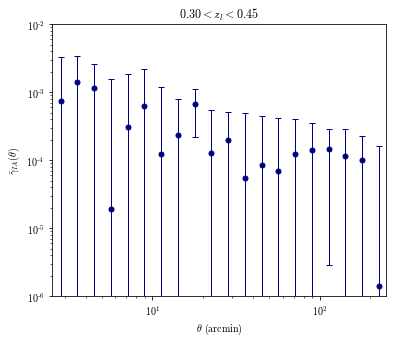

In [30]:
IA_jk = np.zeros([sep_bins])
IA_sig = np.zeros([sep_bins])
theta_final = np.zeros([sep_bins])
for i in range(sep_bins):
    
    bin_patches = IA_patches[:,i] 
    IA_jk[i] = 1.0/npatches * np.sum(bin_patches)
    
    IA_sig[i] = np.sqrt((npatches-1.0)/npatches * np.sum((bin_patches - IA_jk[i])**2))
    
    bin_patches = theta_patches[:,i]
    theta_final[i] = 1.0/npatches * np.sum(bin_patches)   
    
plt.figure(figsize=[6,5])
plt.errorbar(theta_final, IA_final, yerr=IA_sig, lw=0, marker='o', color='navy', markersize=5, elinewidth=1, capsize=3)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-6, 1e-2])
plt.xlim([2.5,250])
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$\bar{\gamma}_{IA}(\theta)$')
plt.title(r'$0.30<z_{l}<0.45$')
plt.savefig('IA_prelim_measurement_(NB2).png', dpi=300)